<font color='red'>QUABOUL Dorian - 3872944</font><br>
<font color='red'>IKHLEF MOUHAMAD - 3870476</font>

## Tâche 2 : Analyse de sentiments, représentations des textes

*Import des librairies*

In [2]:
from os import listdir
from os.path import isfile, join
import re
import string

import spacy
from spacy import displacy
nlp = spacy.load("en_core_web_sm")
from spacy.lang.en.stop_words import STOP_WORDS

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV

import time
import unicodedata

import numpy as np
import matplotlib.pyplot as plt

import sklearn.naive_bayes as bayes
from sklearn import svm, linear_model as lin
from sklearn.model_selection import cross_val_score, StratifiedKFold

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xde in position 0: invalid continuation byte

### Lecture de l'ensemble de revues étiquetées (positifs et négatifs).

In [20]:
posfiles = [f for f in listdir("./movies1000/pos") if isfile(join("./movies1000/pos", f))]
negfiles = [f for f in listdir("./movies1000/neg") if isfile(join("./movies1000/neg", f))]

pos = [open("./movies1000/pos/"+f).read() for f in posfiles]
lab_pos = [1 for _ in range(len(pos))]
neg = [open("./movies1000/neg/"+f).read() for f in negfiles]
lab_neg = [-1 for _ in range(len(neg))]

corpus = pos + neg
labels = np.array(lab_pos + lab_neg)

corpus_test = [t for t in open("./testSentiment.txt", encoding="utf8").read().split("<br /><br />")]
print(corpus_test[50935])

There's not a single good line or character in the whole mess. If there was a plot, it was an afterthought and as far as acting goes, there's nothing good to say so Ill say nothing. I honestly cant understand how this type of nonsense gets produced and actually released, does somebody somewhere not at some stage think, 'Oh my god this really is a load of shite' and call it a day. Its crap like this that has people downloading illegally, the trailer looks like a completely different film, at least if you have download it, you haven't wasted your time or money Don't waste your time, this is painful.



In [17]:
print("Nombre de revues (positives) :",str(len(lab_pos)))
print("Nombre de revues (negatives) :",str(len(lab_neg)))
print("Nombre de revues (test) :",str(len(corpus_test)))

Nombre de revues (positives) : 1000
Nombre de revues (negatives) : 1000
Nombre de revues (test) : 50936


In [5]:
txt = pos[400]
print(txt)
print("-----")
print("NOMBRE DE TOKENS = ",len(txt.split()))

the happy bastard's 30-second review : 
american pie 
the summer of raunch continues to spread into theatres with this latest yuk fest , filled with sick jokes and teen dialogue aplenty . 
if you go expecting dawson's creek , you're in for a problem . 
if your expectations are lower ( and better , i might add ) , you will enjoy the hell out of american pie . 
the movie casts several unknowns , with the only real recognizable one being sctv's own eugene levy as a happy-go-lucky dad . 
the story revolves around four high school seniors who have one goal before the school year gets out- get laid . 
that's pretty much it . 
throughout the movie , little sick comic bits are sprinkled throughout , including a memorable scene involving an apple pie ( i won't give it away , but you probably know what it is ) and an internet broadcast gone horribly awry . 
of course , the movie has some slightly sentimental bits , but they don't drag the movie's humor content down that bad . 
most of the actors

### NLP Preprocessing Pipeline

On s'aperçoit que le texte possède des ponctuations, des caractères spéciaux 
La fonction de preprocessing qui permet de nettoyer et d'épurer une chaîne de caractères

#### [ETAPE 1] Text Normalization/Cleaning

In [3]:
def text_normalization(s):
    # source : http://www-connex.lip6.fr/~guigue/wikihomepage/pmwiki.php?n=Course.CourseTALTME3pp
    
    # elimination tabulations et retours à la ligne
    s = re.sub("\s"," ",re.sub("\s(?=\s)"," ",s))
    # elimination des ponctuations
    punc = '!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~'
    s = s.translate(str.maketrans(punc, ' ' * len(punc)))
    # elimination des chiffres
    s = re.sub('\d+', '', s)
    # elimination des espaces multiples
    s = re.sub(' +', ' ', s)

    return s

In [7]:
step_1 = text_normalization(txt)
print(step_1)
print("-----")
print("NOMBRE DE TOKENS = ",len(step_1.split()))

the happy bastard's second review american pie the summer of raunch continues to spread into theatres with this latest yuk fest filled with sick jokes and teen dialogue aplenty if you go expecting dawson's creek you're in for a problem if your expectations are lower and better i might add you will enjoy the hell out of american pie the movie casts several unknowns with the only real recognizable one being sctv's own eugene levy as a happy go lucky dad the story revolves around four high school seniors who have one goal before the school year gets out get laid that's pretty much it throughout the movie little sick comic bits are sprinkled throughout including a memorable scene involving an apple pie i won't give it away but you probably know what it is and an internet broadcast gone horribly awry of course the movie has some slightly sentimental bits but they don't drag the movie's humor content down that bad most of the actors get their job done but it's levy who's a hoot a father who 

#### [ETAPE 2] POS-Tagging

In [11]:
def display_postagging(s) :
    print(" ".join([w.pos_ for w in nlp(s)]))
    print("-----")
    displacy.render(nlp(s),style="ent",jupyter=True)

In [12]:
display_postagging(step_1)

DET PROPN PROPN PART ADJ NOUN ADJ NOUN DET NOUN ADP NOUN VERB PART VERB ADP NOUN ADP DET ADJ PROPN ADV VERB ADP ADJ NOUN CCONJ ADJ NOUN ADJ SCONJ PRON VERB VERB PROPN PART NOUN PRON AUX ADP ADP DET NOUN SCONJ DET NOUN AUX ADJ CCONJ ADJ PRON VERB VERB PRON VERB VERB DET NOUN SCONJ ADP ADJ NOUN DET NOUN VERB ADJ NOUN ADP DET ADJ ADJ ADJ NOUN AUX PROPN PART ADJ NOUN NOUN SCONJ DET ADJ NOUN ADJ NOUN DET NOUN VERB ADP NUM ADJ NOUN NOUN PRON AUX NUM NOUN ADP DET NOUN NOUN VERB ADP VERB VERB DET AUX ADV ADV PRON ADP DET NOUN ADJ ADJ ADJ NOUN AUX VERB ADP VERB DET ADJ NOUN VERB DET NOUN NOUN PRON VERB PART VERB PRON ADV CCONJ PRON ADV VERB PRON PRON AUX CCONJ DET NOUN NOUN VERB ADV ADV ADP NOUN DET NOUN AUX DET ADV ADJ NOUN CCONJ PRON AUX PART VERB DET NOUN PART NOUN NOUN ADP DET ADJ ADJ ADP DET NOUN VERB DET NOUN VERB CCONJ PRON AUX INTJ PRON AUX DET NOUN DET NOUN PRON VERB PART VERB NOUN ADP DET NOUN ADP DET NOUN ADP DET ADJ ADJ NOUN PRON VERB PART VERB VERB ADP DET NOUN CCONJ SCONJ PRON VER

On ne va garder que les **adjectifs, les adverbes, les noms et les verbes** car les autres catégories de POS-tag (ex : nom propre, déterminant, pronom..) n'ont aucune influence sur la polarité de la phrase

In [4]:
def filter_postagging(s):
    return " ".join([w.text for w in nlp(s) if w.pos_ in ['ADJ','ADV','NOUN','VERB']])

In [14]:
step_2 = filter_postagging(step_1) 
print(" ".join([w.pos_ for w in nlp(step_2) if w.pos_ in ['ADJ','ADV','NOUN','VERB']]))
print("-----")
print(step_2)
print("-----")
print("NOMBRE DE TOKENS = ",len(step_2.split()))

ADJ ADJ NOUN NOUN NOUN VERB NOUN NOUN ADV ADV VERB ADJ NOUN NOUN NOUN ADJ VERB VERB ADJ NOUN NOUN ADV ADJ VERB VERB VERB VERB ADJ NOUN NOUN VERB ADJ NOUN ADV ADJ ADJ ADJ NOUN VERB VERB NOUN VERB ADJ NOUN NOUN NOUN NOUN NOUN VERB VERB ADV ADJ NOUN ADJ ADJ ADJ NOUN VERB VERB ADJ NOUN VERB NOUN NOUN VERB VERB ADV VERB NOUN NOUN VERB ADV ADJ NOUN NOUN ADV ADJ NOUN VERB NOUN NOUN NOUN ADJ ADJ NOUN VERB NOUN VERB VERB NOUN NOUN VERB ADJ ADJ NOUN VERB VERB VERB NOUN VERB VERB NOUN NOUN NOUN ADV ADJ NOUN ADJ NOUN VERB VERB VERB NOUN VERB NOUN ADV
-----
second review american pie summer raunch continues spread theatres latest fest filled sick jokes teen dialogue aplenty go expecting creek problem expectations lower better might add will enjoy hell american pie movie casts several unknowns only real recognizable one own eugene levy happy go lucky dad story revolves high school seniors goal school year gets get laid pretty much movie little sick comic bits sprinkled including memorable scene invo

#### [ETAPE 3a] Stemmatisation

La stemmatisation permet

Nous verrons son impact un peu plus tard dans la campagne d'évaluation

In [5]:
def stemmatisation(s):
    stemmer = SnowballStemmer('english',ignore_stopwords=True)
    words = s.split()
    words_stem = [stemmer.stem(w) for w in words]
    return " ".join(words_stem)

In [23]:
step_3a = stemmatisation(step_2)
print(step_3a)

second review american pie summer raunch continu spread theatr latest fest fill sick joke teen dialogu aplenti go expect creek problem expect lower better might add will enjoy hell american pie movi cast sever unknown only real recogniz one own eugen levi happi go lucki dad stori revolv high school senior goal school year get get laid pretti much movi littl sick comic bit sprinkl includ memor scene involv appl pie wo give away probabl know internet broadcast gone horribl awri cours movi slight sentiment bit drag movi humor content bad most actor get job done hoot father tri talk sex son help curious visual aid could stop laugh movi can stand raunch sex refer then american pie conserv type ll bet having fun home play theatr now


#### [ETAPE 3b]  Lemmatisation

La lemmatisation permet

Nous verrons son impact dans la campagne d'évaluation.

In [6]:
def lemmatisation(s):
    lemmas = [t.lemma_ for t in nlp(s)]
    return " ".join(lemmas)

In [26]:
step_3b = lemmatisation(step_2)
print(step_3b)

second review american pie summer raunch continue spread theatre latest fest fill sick joke teen dialogue aplenty go expect creek problem expectation lower well may add will enjoy hell american pie movie cast several unknown only real recognizable one own eugene levy happy go lucky dad story revolve high school senior goal school year get get lay pretty much movie little sick comic bit sprinkle include memorable scene involve apple pie wo give away probably know internet broadcast go horribly awry course movie slightly sentimental bit drag movie humor content bad most actor get job do hoot father try talk sex son help curious visual aid could stop laugh movie can stand raunch sex reference then american pie conservative type will bet have fun home play theatre now


#### [ETAPE 4] Suppression des Stopwords

Pour l'analyse de sentiment, certains stopwords peuvent s'avérer être très important pour déterminer la polarité d'une phrase ou d'un texte. Comme par exemple "not", "no" etc...

Durant notre campagne d'évaluation, nous allons déterminer quel est le réel impact de ces stopwords.

In [7]:
def delete_stopwords(s,stopwords) :
    tokens = nlp(s)
    return " ".join([w.text for w in tokens if w.text not in stopwords])

In [28]:
print(stopwords.words('english'))
print("-----")
print(len(stopwords.words('english')),"STOPWORDS","[NLTK]")

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [29]:
step_4 = delete_stopwords(step_3b,stopwords.words('english'))
print(step_4)
print("-----")
print("NOMBRE DE TOKENS = ",len(step_4.split()))

second review american pie summer raunch continue spread theatre latest fest fill sick joke teen dialogue aplenty go expect creek problem expectation lower well may add enjoy hell american pie movie cast several unknown real recognizable one eugene levy happy go lucky dad story revolve high school senior goal school year get get lay pretty much movie little sick comic bit sprinkle include memorable scene involve apple pie wo give away probably know internet broadcast go horribly awry course movie slightly sentimental bit drag movie humor content bad actor get job hoot father try talk sex son help curious visual aid could stop laugh movie stand raunch sex reference american pie conservative type bet fun home play theatre
-----
NOMBRE DE TOKENS =  118


In [30]:
print(STOP_WORDS)
print("-----")
print(len(STOP_WORDS),"STOPWORDS","[SPACY]")

{'neither', 'once', 'since', 'as', 'only', 'thru', 'anyhow', 'yourself', 'least', 'get', 'former', 'name', 'behind', 'even', 'still', 'go', 'nor', 'elsewhere', 'whom', 'itself', 'your', 'quite', 'side', 'along', 'eleven', 'give', 'thereafter', 'therefore', 'else', 'herein', 'top', 'further', 'himself', 'sixty', 'out', 'again', 'namely', 'its', 'sometimes', 'twelve', 'beyond', 'where', 'both', 'within', 'somewhere', 'themselves', 'then', 'those', 'fifteen', 'same', 'forty', 'at', 'thereupon', 'such', 'more', 'alone', 'nowhere', '‘m', 'hence', 'although', 'several', 'become', 'there', 'whereafter', 'me', 'twenty', 'make', 'various', 'put', 'while', 'an', 'something', 'wherein', 'by', 'most', 'latterly', 'almost', 'seemed', 'four', 'through', 'were', 'therein', 'seems', 'hers', 'serious', 'n‘t', 'everything', 'they', 'nothing', 'our', 'has', 'third', 'indeed', 'until', 'though', 'hereby', 'five', 'about', 'who', 'formerly', 'always', 'when', 'whither', 'before', 'from', 'afterwards', 'you

In [31]:
step_4 = delete_stopwords(step_3b, STOP_WORDS)
print(step_4)
print("-----")
print("NOMBRE DE TOKENS = ",len(step_4.split()))

second review american pie summer raunch continue spread theatre latest fest fill sick joke teen dialogue aplenty expect creek problem expectation lower add enjoy hell american pie movie cast unknown real recognizable eugene levy happy lucky dad story revolve high school senior goal school year lay pretty movie little sick comic bit sprinkle include memorable scene involve apple pie wo away probably know internet broadcast horribly awry course movie slightly sentimental bit drag movie humor content bad actor job hoot father try talk sex son help curious visual aid stop laugh movie stand raunch sex reference american pie conservative type bet fun home play theatre
-----
NOMBRE DE TOKENS =  105


In [8]:
fusion_stopwords = set(stopwords.words('english')).union(STOP_WORDS)
print(fusion_stopwords)
print("-----")
print(len(fusion_stopwords),"STOPWORDS","[NLTK+SPACY]")

{'either', 'much', 'yet', 's', 'side', 'mustn', "mustn't", 'own', 'has', 'our', 'some', 'meanwhile', 'ever', 'least', "it's", 'under', 'three', 'itself', 'beside', 'hence', 'seeming', 'all', 'nowhere', 'across', '’m', 'because', 'becomes', 'doing', 'would', 'towards', 'other', 'too', 're', 'else', 'someone', 'enough', 'aren', '’re', 'onto', 'yourselves', 'after', 'an', 'him', 'besides', 'somewhere', 'therefore', 'why', 'please', 'your', 'off', 'wherever', "doesn't", 'everything', "n't", 'themselves', 'her', 'anyhow', 'so', 'anything', 'whither', '‘d', 'regarding', "she's", 'until', 'ours', 'at', 'though', 'can', 'once', "won't", 'am', 'that', 'when', 'few', 'or', 'their', 'whether', 'name', 'made', 'less', 'ten', "hasn't", 'thus', 'about', 'nothing', 'he', 'whenever', 'may', "mightn't", 'anywhere', 'being', "you'll", 'of', 'again', 'former', 'hereupon', 'wherein', 'n’t', 'elsewhere', 'above', 'twelve', 'throughout', 'n‘t', 'now', 'seemed', 'top', 'my', 'no', 'won', 'something', "'ve", 

In [33]:
step_4 = delete_stopwords(step_3b, fusion_stopwords)
print(step_4)
print("-----")
print("NOMBRE DE TOKENS = ",len(step_4.split()))

second review american pie summer raunch continue spread theatre latest fest fill sick joke teen dialogue aplenty expect creek problem expectation lower add enjoy hell american pie movie cast unknown real recognizable eugene levy happy lucky dad story revolve high school senior goal school year lay pretty movie little sick comic bit sprinkle include memorable scene involve apple pie wo away probably know internet broadcast horribly awry course movie slightly sentimental bit drag movie humor content bad actor job hoot father try talk sex son help curious visual aid stop laugh movie stand raunch sex reference american pie conservative type bet fun home play theatre
-----
NOMBRE DE TOKENS =  105


#### Pipeline du preprocessing

Cette fonction résume les différentes étape de la "pipeline" du preprocessing. Elle sera utilisée lors de la campagne d'évaluation.

In [9]:
def preprocessing(s,option,stopwords) :
    if option == "stema" :
        if stopwords :
            return delete_stopwords(stemmatisation(filter_postagging(text_normalization(s))),stopwords)
        else :
            return stemmatisation(filter_postagging(text_normalization(s)))
    elif option == "lema" :
        if stopwords :
            return delete_stopwords(lemmatisation(filter_postagging(text_normalization(s))),stopwords)
        else :
            return lemmatisation(filter_postagging(text_normalization(s)))
    else :
        if stopwords :
            return delete_stopwords(filter_postagging(text_normalization(s)),stopwords)
        else :
            return filter_postagging(text_normalization(s))

### Exploration et analyse de la matrice Document-Term

#### Construction des différents corpus

In [10]:
# On garde les stopwords
corpus_ = [preprocessing(d,"none",None) for d in corpus]
corpus_lema = [preprocessing(d,"lema",None) for d in corpus]
corpus_stema = [preprocessing(d,"stema",None) for d in corpus]
# On supprime les stopwords
corpus_sw = [preprocessing(d,"none",fusion_stopwords) for d in corpus]
corpus_sw_lema = [preprocessing(d,"lema",fusion_stopwords) for d in corpus]
corpus_sw_stema = [preprocessing(d,"stema",fusion_stopwords) for d in corpus]

all_corpus = [[corpus_, corpus_lema, corpus_stema],
              [corpus_sw, corpus_sw_lema, corpus_sw_stema]]

#### [ETAPE 5] CountVectorizer

On va se concentrer sur le *corpus_sw_lema* pour explorer la matrice Document-Term et optimiser les différents hyper-paramètres des modèles qu'on va manipuler.

In [52]:
vectorizer = CountVectorizer(min_df=2)
X = vectorizer.fit_transform(corpus_sw_lema)

In [53]:
vocab = np.array(vectorizer.get_feature_names())

print("Nombre de mots dans le vocabulaire : ", len(vocab))
print("30 mots du vocabulaire : ", vocab[5500:5530])

Nombre de mots dans le vocabulaire :  15455
30 mots du vocabulaire :  ['fully' 'fumble' 'fumbling' 'fume' 'fun' 'function' 'functional'
 'functionary' 'functioning' 'fund' 'fundamental' 'fundamentalist'
 'fundamentally' 'funding' 'fundraiser' 'funeral' 'funky' 'funnel'
 'funner' 'funnest' 'funnier' 'funniest' 'funny' 'fur' 'furious'
 'furiously' 'furnish' 'furnishing' 'furniture' 'furrow']


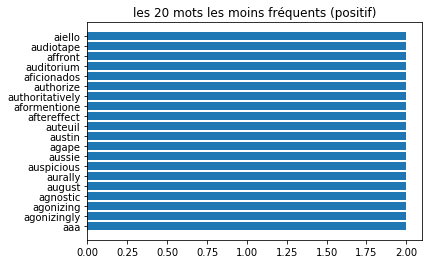

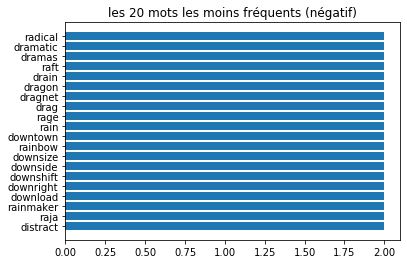

In [54]:
tf_pos = X.toarray().sum(0)[:1000]
tf_neg = X.toarray().sum(0)[1000:]

n = 20

ind_p = tf_pos.argsort()[:n]
ind_n = tf_neg.argsort()[:n]

plt.barh(vocab[ind_p], tf_pos[ind_p])
plt.title("les "+str(n)+" mots les moins fréquents (positif)")
plt.show()

plt.barh(vocab[ind_n], tf_neg[ind_n])
plt.title("les "+str(n)+" mots les moins fréquents (négatif)")
plt.show()

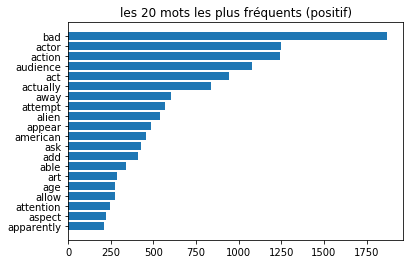

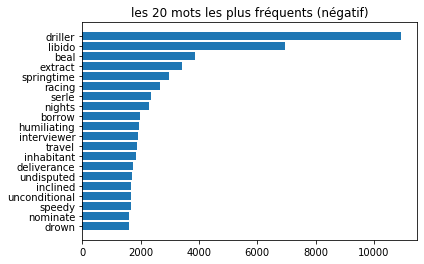

In [55]:
ind_p = tf_pos.argsort()[-n:]
ind_n = tf_neg.argsort()[-n:]

plt.barh(vocab[ind_p], tf_pos[ind_p])
plt.title("les "+str(n)+" mots les plus fréquents (positif)")
plt.show()

plt.barh(vocab[ind_n], tf_neg[ind_n])
plt.title("les "+str(n)+" mots les plus fréquents (négatif)")
plt.show()

### Optimisation des hyper-paramètres des modèles

In [11]:
def findBestHyperParam(name_clf, X_train, y_train,):
    if name_clf == "[reg_logistic]" :
        
        logistic = lin.LogisticRegression()

        param_grid = {'penalty':['l1', 'l2'],
                      'C':[0.01, 0.1, 1, 10, 100],
                      'solver':['liblinear', 'saga']}

        grid = GridSearchCV(estimator=logistic,
                            param_grid=param_grid,
                            scoring='accuracy',
                            verbose=1,
                            n_jobs=-1,
                            cv = 5)
        
        grid_result = grid.fit(X_train, y_train)

        print('Best Score: ', grid_result.best_score_)
        print('Best Params: ', grid_result.best_params_)
        
        return grid_result.best_estimator_
    
    elif name_clf == "[bayes]" :
        
        multi_nb = bayes.MultinomialNB()
        
        param_grid = {'alpha': [0,0.1,1,10,100]}
        
        grid = GridSearchCV(estimator=multi_nb,
                            param_grid=param_grid,
                            scoring='accuracy',
                            verbose=1,
                            n_jobs=-1,
                            cv = 5)
        
        grid_result = grid.fit(X_train, y_train)
        
        print('Best Score: ', grid_result.best_score_)
        print('Best Params: ', grid_result.best_params_)
        
        return grid_result.best_estimator_
        
    elif name_clf == "[svm]" :
        
        svc = svm.SVC()
        
        param_grid = {'C': [0.01, 0.1, 1, 10, 100], 
                      'gamma': [1,0.1,0.01,0.001],
                      'kernel': ['rbf', 'poly', 'sigmoid']}
        
        grid = GridSearchCV(estimator=svc,
                            param_grid=param_grid,
                            scoring='accuracy',
                            verbose=1,
                            n_jobs=-1,
                            cv = 5)
        
        grid_result = grid.fit(X_train, y_train)
        
        print('Best Score: ', grid_result.best_score_)
        print('Best Params: ', grid_result.best_params_)
        
        return grid_result.best_estimator_
    else :
        print("Le nom du modèle ne comvient pas pour cette fonction !")  

Recherche du meilleur du hyper-paramètre *Multinomial Naive Bayes* :
- alpha

In [87]:
best_multinb = findBestHyperParam("[bayes]", X, labels)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best Score:  0.8150000000000001
Best Params:  {'alpha': 1}


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.8s finished


Recherche des meilleurs hyper-paramètres pour *SVM* :
- C
- kernel
- gamma

In [88]:
best_svm = findBestHyperParam("[svm]", X, labels)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 18.1min finished


Best Score:  0.8234999999999999
Best Params:  {'C': 10, 'gamma': 0.001, 'kernel': 'rbf', 'max_iter': 5000}


Recherche des meilleurs hyper-paramètres pour *Régression Logistique* :
- C
- penality
- solver

In [91]:
best_reg_logistic = findBestHyperParam("[reg_logistic]", X, labels)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 392 tasks      | elapsed: 16.4min


KeyboardInterrupt: 

## Campagne d'évaluation et comparaison de 3 modèles de classification

Cette campagne d'évaluation va consister à choisir les meilleurs paramètres pour déterminer la classe d'un avis.

Les paramètres qui seront modulés :
- avec ou sans Stopwords
- Unigram/Bigram/Trigram
- Stemmatisation/Lemmatisation

In [120]:
def campagne_evaluation(corpus, labels, stop_words, ngram, classifieur, clf):

    tic = time.perf_counter() 
    
    ordinates = [[] for i in range(12)]
    abscissas = [[] for i in range(12)]
    cpt = 0

    for tab in corpus :
        for c in tab :
            abscissas[cpt] = np.linspace(20, get_len_vocab(c, ngram), 20, dtype = int)
            abscissas[cpt+1] = np.linspace(20, get_len_vocab(c, ngram), 20, dtype = int)
            for step in abscissas[cpt]:
                vectorizer = CountVectorizer(max_features=step, ngram_range=(1,ngram), min_df = 2)
                tf_idf = TfidfVectorizer(max_features=step, ngram_range=(1,ngram))
                X_v = vectorizer.fit_transform(c)
                X_t = tf_idf.fit_transform(c)
                ordinates[cpt].append(cross_validation(clf, X_v, labels))
                ordinates[cpt+1].append(cross_validation(clf, X_t, labels))
            cpt+=2
             
    print("Temps d'éxécution : "+str(round(time.perf_counter()-tic, 2))+" secondes")
    
    labels = ['TF','TFIDF',
              'TF-LEMA','TFIDF-LEMA', 
              'TF-STEMA','TFIDF-STEMA',
              'TF-STPW','TFIDF-STPW',
              'TF-STPW-LEMA','TFIDF-STPW-LEMA',
              'TF-STPW-STEMA','TFIDF-STPW-STEMA']
    
    for j in range(12) :
        plt.plot(abscissas[j], ordinates[j], label=labels[j])
        plt.legend()
        
    plt.title(classifieur + " - Accuracy en fonction du nb de mots conservés : "+mot_gram(ngram))
    plt.xlabel("Nombre de mots conservés")
    plt.ylabel("Accuracy")
    plt.show()
    
    ind = [np.argmax(o) for o in ordinates]
    max_gram = [abscissas[_][ind[_]] for _ in range(12)] 

    for _ in range(12):
        print("Meilleur score <"+str(ordinates[_][ind[_]])+"> pour",labels[_],"avec "+(str(max_gram[_]))+" "+mot_gram(ngram))

    return max_gram

In [108]:
def cross_validation(clf, X, y, n_splits=5):
    scores = []
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        scores.append(clf.score(X_test,y_test))
        
    return sum(scores)/n_splits

In [109]:
def get_len_vocab(corpus, ngram):
    vectorizer = CountVectorizer(ngram_range = (1,ngram))
    vectorizer.fit_transform(corpus)
    return len(vectorizer.get_feature_names())

In [110]:
def mot_gram(ngram):
    if ngram == 1:
        return "unigrams"
    elif ngram == 2:
        return "bigrams"
    elif ngram == 3:
        return "trigrams"
    else:
        return "ngrams"

### 1-Naive Bayes

UNIGRAM

Temps d'éxécution : 129.17 secondes


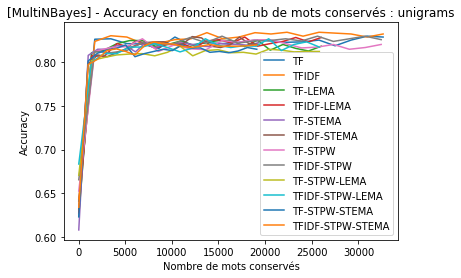

Meilleur score <0.8300000000000001> pour TF avec 30932 unigrams
Meilleur score <0.8345> pour TFIDF avec 22345 unigrams
Meilleur score <0.8254999999999999> pour TF-LEMA avec 19178 unigrams
Meilleur score <0.829> pour TFIDF-LEMA avec 17810 unigrams
Meilleur score <0.8225> pour TF-STEMA avec 11165 unigrams
Meilleur score <0.8295000000000001> pour TFIDF-STEMA avec 12178 unigrams
Meilleur score <0.827> pour TF-STPW avec 6845 unigrams
Meilleur score <0.8300000000000001> pour TFIDF-STPW avec 25615 unigrams
Meilleur score <0.8185> pour TF-STPW-LEMA avec 10879 unigrams
Meilleur score <0.827> pour TFIDF-STPW-LEMA avec 13594 unigrams
Meilleur score <0.8200000000000001> pour TF-STPW-STEMA avec 11068 unigrams
Meilleur score <0.8234999999999999> pour TFIDF-STPW-STEMA avec 8055 unigrams


In [121]:
bayes1 = campagne_evaluation(all_corpus, np.array(labels), fusion_stopwords, 1, "[MultiNBayes]",best_multinb)

BIGRAM

Temps d'éxécution : 582.81 secondes


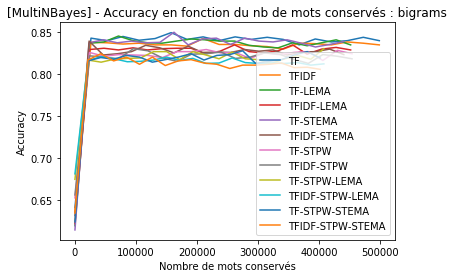

Meilleur score <0.849> pour TF avec 157584 bigrams
Meilleur score <0.842> pour TFIDF avec 210105 bigrams
Meilleur score <0.845> pour TF-LEMA avec 71381 bigrams
Meilleur score <0.8345> pour TFIDF-LEMA avec 261679 bigrams
Meilleur score <0.8494999999999999> pour TF-STEMA avec 162385 bigrams
Meilleur score <0.8390000000000001> pour TFIDF-STEMA avec 23215 bigrams
Meilleur score <0.829> pour TF-STPW avec 215162 bigrams
Meilleur score <0.8300000000000001> pour TFIDF-STPW avec 95638 bigrams
Meilleur score <0.8300000000000001> pour TF-STPW-LEMA avec 408087 bigrams
Meilleur score <0.8204999999999998> pour TFIDF-STPW-LEMA avec 42974 bigrams
Meilleur score <0.8275> pour TF-STPW-STEMA avec 274989 bigrams
Meilleur score <0.8240000000000001> pour TFIDF-STPW-STEMA avec 42323 bigrams


In [122]:
bayes2 = campagne_evaluation(all_corpus, np.array(labels), fusion_stopwords, 2, "[MultiNBayes]",best_multinb)

TRIGRAM

Temps d'éxécution : 1189.08 secondes


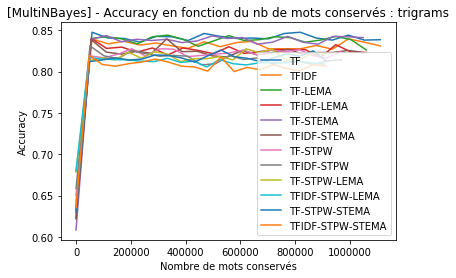

Meilleur score <0.8475000000000001> pour TF avec 58505 trigrams
Meilleur score <0.8394999999999999> pour TFIDF avec 58505 trigrams
Meilleur score <0.844> pour TF-LEMA avec 334748 trigrams
Meilleur score <0.8400000000000001> pour TFIDF-LEMA avec 55808 trigrams
Meilleur score <0.8435> pour TF-STEMA avec 110446 trigrams
Meilleur score <0.8394999999999999> pour TFIDF-STEMA avec 331300 trigrams
Meilleur score <0.8275> pour TF-STPW avec 203940 trigrams
Meilleur score <0.8310000000000001> pour TFIDF-STPW avec 51000 trigrams
Meilleur score <0.8274999999999999> pour TF-STPW-LEMA avec 620557 trigrams
Meilleur score <0.817> pour TFIDF-STPW-LEMA avec 47753 trigrams
Meilleur score <0.826> pour TF-STPW-STEMA avec 529087 trigrams
Meilleur score <0.8195> pour TFIDF-STPW-STEMA avec 48117 trigrams


In [123]:
bayes3 = campagne_evaluation(all_corpus, np.array(labels), fusion_stopwords, 3, "[MultiNBayes]",best_multinb)

### 2- SVM

UNIGRAM

In [ ]:
svm1 = campagne_evaluation(all_corpus, np.array(labels), fusion_stopwords, 1, "[SVM]",best_svm)

BIGRAM

In [ ]:
svm2 = campagne_evaluation(all_corpus, np.array(labels), fusion_stopwords, 2, "[SVM]",best_svm)

TRIGRAM

In [ ]:
svm3 = campagne_evaluation(all_corpus, np.array(labels), fusion_stopwords, 3, "[SVM]",best_svm)

### 3- Régression Logistique

UNIGRAM

In [ ]:
logistic1 = campagne_evaluation(corpus, np.array(labels), fusion_stopwords, 1, "[Reg_Logistic]",best)

BIGRAM

In [ ]:
logistic2 = campagne_evaluation(corpus, np.array(labels), fusion_stopwords, 2, "[Reg_Logistic]")

TRIGRAM

In [ ]:
logistic3 = campagne_evaluation(corpus, np.array(labels), fusion_stopwords, 3, "[Reg_Logistic]")

## Génération des prédictions pour le dataset de test

Selon la campagne d'évaluation, ...

In [22]:
def generate_file_predict_test(predictions,nom_clf, tfidf, sw, ngram) :
    filename = "predict_"+nom_clf+"_"+tfidf+"_"+sw+"_"+ngram+"gram"+".txt"
    
    with open(filename, "w") as f:
        for p in predictions :
            f.write("%s\n" % str(p))

On transforme le corpus de test en matrice sparse à partir des mots du vocabulaire contenus dans le vectorizer

In [21]:
"""best_clf = lin.LogisticRegression(max_iter = 1000)

best_vectorizer = CountVectorizer(max_features=lin2[2], ngram_range=(1,2))
X = best_vectorizer.fit_transform(corpus_train)
best_clf.fit(X,labels_train)

X_test = best_vectorizer.transform(corpus_test)
predictions = best_clf.predict(X_test)
generate_file_test(predictions,"reglog","tf","sw","bigram")"""

'best_clf = lin.LogisticRegression(max_iter = 1000)\n\nbest_vectorizer = CountVectorizer(max_features=lin2[2], ngram_range=(1,2))\nX = best_vectorizer.fit_transform(corpus_train)\nbest_clf.fit(X,labels_train)\n\nX_test = best_vectorizer.transform(corpus_test)\npredictions = best_clf.predict(X_test)\ngenerate_file_test(predictions,"reglog","tf","sw","bigram")'

# Conclusion